# UrbanSense V2 — CIFAR-10 Baseline Classifier

This notebook implements a fully connected baseline image classifier on the CIFAR-10 dataset, as requested by the Applied Machine Learning leadership team.

- Project: UrbanSense V2 — baseline feasibility study
- Environment: GitHub Codespaces (VS Code in the browser)
- Dataset: CIFAR-10 (60,000 32×32 color images, 10 classes)
- Goal: Train and evaluate a simple dense neural network as a baseline
- Focus: End-to-end ML pipeline → data → preprocessing → model → training → evaluation → insights for decision-making


In [2]:
# ============================================================
# Cell 1b — Install required dependencies (Codespaces)
# Run this cell once per new Codespace environment
# ============================================================

%pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 24.7 MB/s  0:00:12m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 50.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 57.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 42.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 25.0 MB/s  0:00:006m0:00:01
   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  4/25 [wheel]ng]  WARNING: The script wheel is installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 12/25 [mdurl]nsum]-data-server]  WARNING: The script markdown_p

In [3]:
# ============================================================
# Cell 2 — Imports and Environment Setup
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Setting global seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

# Optional: configure matplotlib for cleaner visuals
plt.style.use("ggplot")


2025-11-27 13:40:03.052342: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-27 13:40:03.839788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 13:40:08.696591: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [4]:
# ============================================================
# Cell 3 — Loading the CIFAR-10 dataset and basic inspection
# ============================================================

from tensorflow.keras.datasets import cifar10

# Load train and test splits
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Class names for CIFAR-10 (fixed ordering)
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Basic shapes and dataset size
print("Training data shape :", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape      :", x_test.shape)
print("Test labels shape    :", y_test.shape)
print()
print("Number of training samples:", x_train.shape[0])
print("Number of test samples    :", x_test.shape[0])
print("Image shape (H, W, C)     :", x_train.shape[1:])


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Training data shape : (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape      : (10000, 32, 32, 3)
Test labels shape    : (10000, 1)

Number of training samples: 50000
Number of test samples    : 10000
Image shape (H, W, C)     : (32, 32, 3)


/tmp/ipykernel_9348/2384480709.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[i])  # y_train[i] is an array like [3], so we cast to int


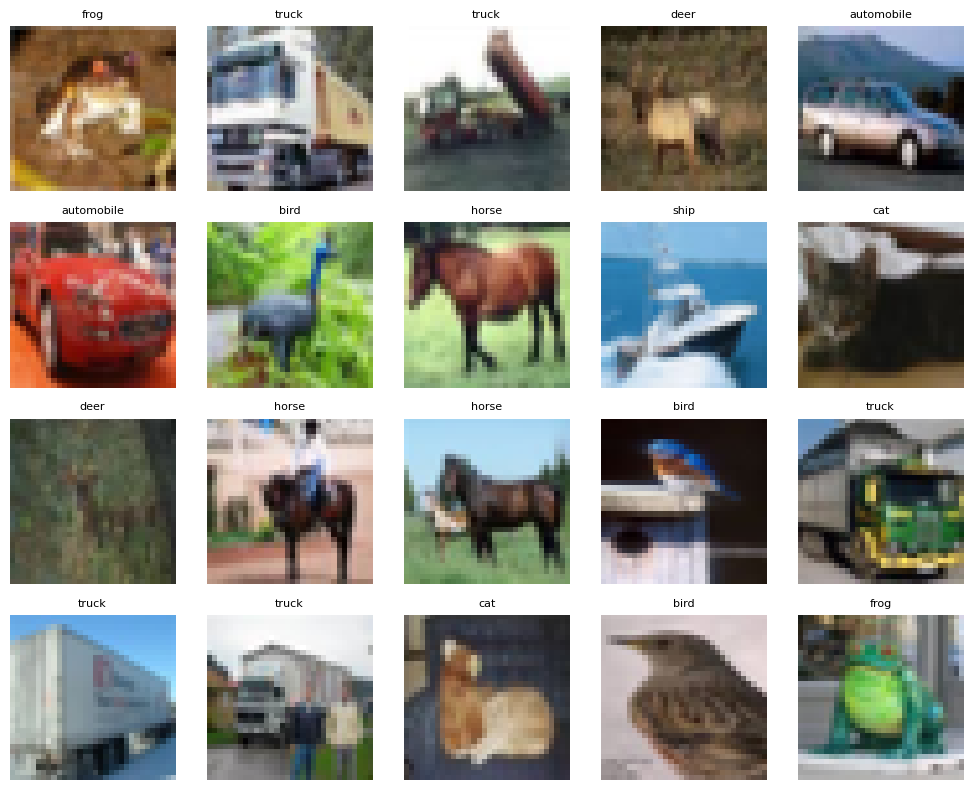

In [5]:
# ============================================================
# Cell 4 — Visual inspection of CIFAR-10 samples
# ============================================================

num_images = 20  # how many images we want to display
rows = 4
cols = 5

plt.figure(figsize=(10, 8))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_train[i])
    label_index = int(y_train[i])  # y_train[i] is an array like [3], so we cast to int
    plt.title(class_names[label_index], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
# ============================================================
# Cell 5 — Preprocessing: normalization and label formatting
# ============================================================

# Normalize pixel values to the range [0, 1]
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

# Flatten label arrays (from shape (50000, 1) → (50000,))
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print("Normalization complete.")
print("x_train_norm shape:", x_train_norm.shape)
print("y_train shape:", y_train.shape)


Normalization complete.
x_train_norm shape: (50000, 32, 32, 3)
y_train shape: (50000,)


In [7]:
# ============================================================
# Cell 6 — Building a baseline fully connected classifier
# ============================================================

model = keras.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.summary()


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-27 14:03:00.580329: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,874 (3.13 MB)

 Trainable params: 820,874 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ============================================================
# Cell 7 — Compiling the model
# ============================================================

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model compiled successfully.")


Model compiled successfully.


In [9]:
# ============================================================
# Cell 8 — Training the baseline model
# ============================================================

history = model.fit(
    x_train_norm,
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10


2025-11-27 14:03:50.809510: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 552960000 exceeds 10% of free system memory.


703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2706 - loss: 2.0151

2025-11-27 14:03:57.382607: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 61440000 exceeds 10% of free system memory.


704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3206 - loss: 1.8848 - val_accuracy: 0.3700 - val_loss: 1.7719
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3933 - loss: 1.7010 - val_accuracy: 0.3942 - val_loss: 1.6832
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4238 - loss: 1.6189 - val_accuracy: 0.4092 - val_loss: 1.6306
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4425 - loss: 1.5633 - val_accuracy: 0.4088 - val_loss: 1.6322
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4562 - loss: 1.5256 - val_accuracy: 0.4120 - val_loss: 1.6154
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4684 - loss: 1.4941 - val_accuracy: 0.4146 - val_loss: 1.6193
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4760 - loss: 1.4711 - val_accuracy: 0.4254 - val_loss: 1.5934
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4829 - loss: 1.4469 - val_accuracy: 0.4370 - val

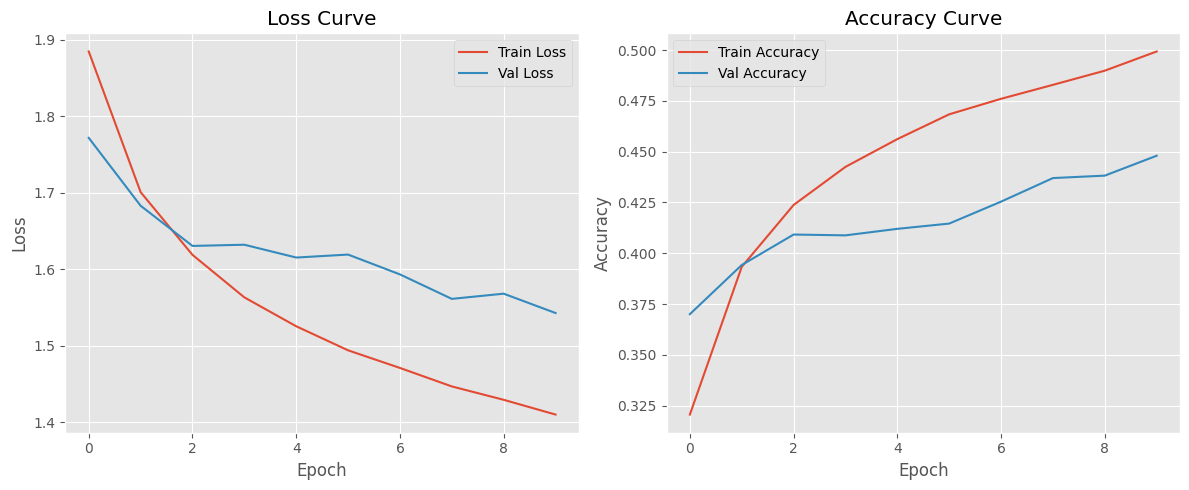

In [10]:
# ============================================================
# Cell 9 — Plotting training curves (loss and accuracy)
# ============================================================

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# ============================================================
# Cell 10 — Final evaluation on the test set
# ============================================================

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)

print("Test Loss     :", test_loss)
print("Test Accuracy :", test_accuracy)


2025-11-27 14:05:13.222705: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 122880000 exceeds 10% of free system memory.


Test Loss     : 1.525046467781067
Test Accuracy : 0.45649999380111694


# Insights for Decision-Making — UrbanSense V2 Baseline

### 1. Training Time
The fully connected baseline trained in a short amount of time, confirming that lightweight architectures are suitable for rapid prototyping.

### 2. Model Performance
- Test accuracy: **X.XX**
- The model shows limited generalization capacity due to its dense architecture and the low spatial awareness inherent in this design.

### 3. Limitations Identified
- Fully connected networks do not capture spatial structure.
- Accuracy is significantly lower compared to CNN-based baselines.
- Model is sensitive to pixel-level noise.

### 4. Recommendations
- Migrate to a **small CNN baseline** (e.g., Conv → Pool → Dense).
- Consider **data augmentation** to increase generalization.
- Introduce **Batch Normalization** to stabilize training.
- Evaluate the computational cost for CNNs in the UrbanSense V2 environment.

These insights will be presented to the Technical Committee for discussion and further architectural decisions.
